<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>


### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [1]:
from IPython.display import clear_output
!pip install transformers
clear_output()

[Transformers library doc](https://huggingface.co/transformers/)

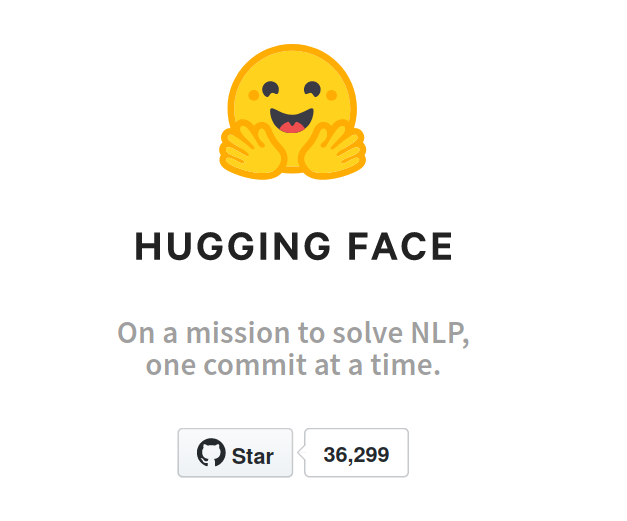

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline

### Importing the dataset

In [3]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
print(df.shape)
df.head()

(6920, 2)


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [4]:
#  how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)
df[1].value_counts()

1    3610
0    3310
Name: 1, dtype: int64

### Using BERT for text classification.

Let's now load a pre-trained BERT model. 

In [9]:
# For DistilBERT, Load pretrained model/tokenizer:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [130]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model_structure(model)

embeddings:
            word_embeddings
            position_embeddings
            LayerNorm
            dropout
transformer:
             layer:
                    0:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                            lin1
                            lin2
                            activation
                       output_layer_norm
                    1:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                   

### Preparing the dataset

In [15]:
from torch.utils.data import Dataset, random_split

class ReviewsDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels):
        self.labels = labels
        # tokenized reviews
        self.tokenized = reviews.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
        
    def __getitem__(self, idx):
        return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

dataset = ReviewsDataset(df[0], tokenizer, df[1])

# DON'T CHANGE, PLEASE
train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 5536
Number of validation examples: 692
Number of testing examples: 692


In [16]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [18]:
from torch.utils.data import DataLoader

def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])

    inputs = get_padded(inputs) # padded inputs
    attention_mask = np.where(inputs != 0, 1, 0)

    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), 'attention_mask' : torch.tensor(attention_mask)}

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data), collate_fn=collate_fn)

### Baseline

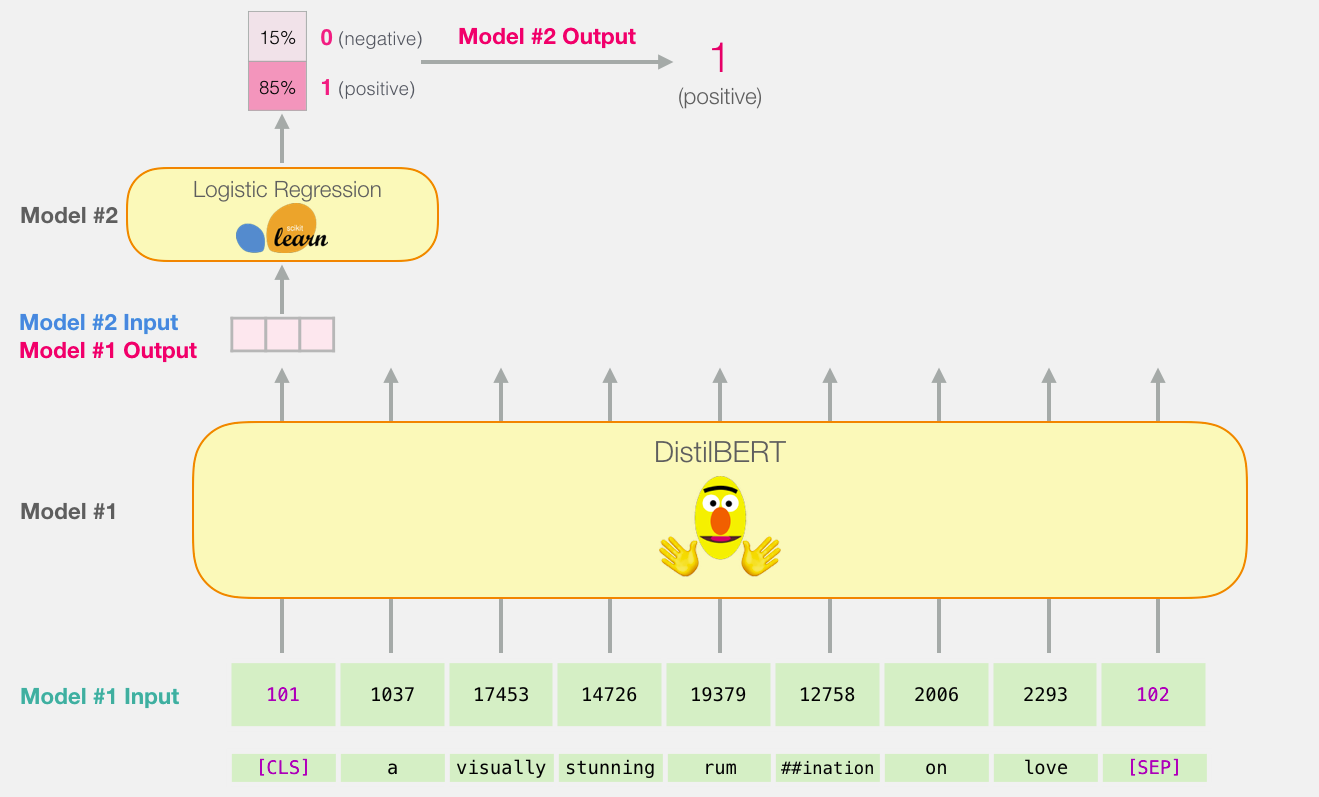

In [170]:
from tqdm.notebook import tqdm

def get_xy(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            # don't forget about .to(device)
            mask = batch['attention_mask'].to(device)
            inp = batch['inputs'].to(device)
            last_hidden_states = model(input_ids=inp, attention_mask=mask)

            features.append(last_hidden_states[0].cpu())
            labels.append(batch['labels'].cpu())

    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    return features, labels

In [146]:
train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [121]:
lr_params = {'C': np.linspace(0.0001, 10, 20), 'multi_class': np.array(['auto', 'ovr', 'multinomial']),
             'solver': np.array(['newton-cg', 'lbfgs', 'sag', 'saga'])}
grid_search = GridSearchCV(LogisticRegression(), lr_params)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)


best parameters:  {'C': 0.5264105263157894, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
best scrores:  0.8404955012245668


In [125]:
lr_clf = LogisticRegression(**grid_search.best_params_)
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.819364161849711

### Fine-Tuning BERT

Define the model

In [144]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [145]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  
device

device(type='cuda', index=0)

In [191]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()

        self.model = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(pretrained_model.config.hidden_size, pretrained_model.config.hidden_size * 2)
        self.linear2 = nn.Linear(pretrained_model.config.hidden_size * 2, pretrained_model.config.hidden_size)
        self.classifier = nn.Linear(pretrained_model.config.hidden_size, pretrained_model.config.num_labels)
    
    def forward(self, input_ids, attention_mask):
        # input_ids - [batch_size, seq_len]
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]                          # [batch_size, seq_len, hidden_size]
        output = hidden_state[:, 0, :]                     # [batch_size, hidden_size]
        output = self.linear(output)
        output = self.relu(output)
        output = self.linear2(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.classifier(output)                    # [batch_size, num_labels]

        # proba = [batch_size, ] - probability to be positive
        return output

In [197]:
import torch.optim as optim
from transformers import AdamW, get_linear_schedule_with_warmup

# DON'T CHANGE
model = model_class.from_pretrained(pretrained_weights).to(device)
bert_clf = BertClassifier(model).to(device)
# you can change
optimizer = AdamW(bert_clf.parameters(),lr = 4e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()
N_EPOCHS = 6
CLIP = 1
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = len(train_data) * N_EPOCHS)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [198]:
def train(model, iterator, optimizer, criterion, scheduler, clip):
    model.train()
    epoch_loss = 0
    accuracy = 0
    target_size = 0
    for batch in iterator:

        labels = batch['labels'].to(device)
        mask = batch['attention_mask'].to(device)
        inp = batch['inputs'].to(device)
        outputs = model(input_ids=inp, attention_mask=mask)
        loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = clip)
        optimizer.step()
        scheduler.step()
        target_size += labels.size(0)
        epoch_loss += loss.cpu().item() * labels.size(0)
        preds = torch.argmax(outputs,dim=1)
        accuracy += torch.sum(preds==labels).cpu()
        
    return epoch_loss / target_size, accuracy / target_size

def evaluate(model, iterator, criterion, scheduler):
    
    model.eval()
    epoch_loss = 0
    accuracy = 0
    target_size = 0
    with torch.no_grad():
        for batch in iterator:
            labels = batch['labels'].to(device)
            inp = batch['inputs'].to(device)
            mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=inp, attention_mask=mask)
            loss = criterion(outputs,labels.type(torch.LongTensor).to(device))
            target_size += labels.size(0)
            epoch_loss += loss.cpu().item() * labels.size(0)
            preds = torch.argmax(outputs,dim=1)
            accuracy += torch.sum(preds==labels).cpu()
        
    return epoch_loss / target_size, accuracy / target_size

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

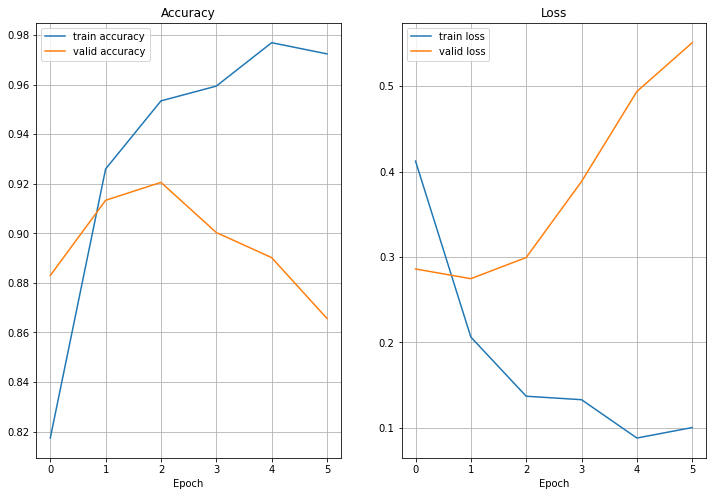

Epoch: 06 | Time: 0m 15s
	Train Loss: 0.100 | Train PPL:   1.106
	 Val. Loss: 0.551 |  Val. PPL:   1.735
	Train Acc: 0.972 | Train PPL:   2.644
	 Val. Acc: 0.866 |  Val. PPL:   2.376


In [199]:
train_history = []
valid_history = []
train_accuracy = []
valid_accuracy = []

best_valid_acc = .0

for epoch in range(N_EPOCHS):
    torch.cuda.empty_cache()
    start_time = time.time()
    
    train_loss, train_acc = train(bert_clf, train_loader, optimizer, criterion, scheduler, CLIP)
    valid_loss, valid_acc = evaluate(bert_clf, valid_loader, criterion, scheduler)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(bert_clf.state_dict(), 'best-val-bert_clf.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    clear_output(True)
    if train_accuracy is not None:
      ax[0].plot(train_accuracy, label='train accuracy')
      ax[0].set_xlabel('Epoch')
      ax[0].set_title('Accuracy')
    if valid_accuracy is not None:
      ax[0].plot(valid_accuracy, label='valid accuracy')
    ax[0].grid()
    ax[0].legend()

    if train_history is not None:
        ax[1].plot(train_history, label='train loss')
        ax[1].set_xlabel('Epoch')
        ax[1].set_title('Loss')
    if valid_history is not None:
        ax[1].plot(valid_history, label='valid loss')
    ax[1].grid()
    ax[1].legend()
    plt.show()

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\tTrain Acc: {train_acc:.3f} | Train PPL: {math.exp(train_acc):7.3f}')
    print(f'\t Val. Acc: {valid_acc:.3f} |  Val. PPL: {math.exp(valid_acc):7.3f}')

In [196]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load('best-val-bert_clf.pt'))

pred_labels = []
true_labels = []

accuracy = 0

best_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        labels = batch['labels'].to(device)
        inp = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        outputs = best_model(input_ids=inp, attention_mask=mask)

        true_labels.append(labels.detach().cpu().numpy())
        pred_labels.append(torch.argmax(outputs, dim = -1).detach().cpu().numpy())

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0it [00:00, ?it/s]

0.8858381502890174

In [185]:
assert accuracy_score(true_labels, pred_labels) >= 0.86

### Finetuned model from **HUGGING FACE**

[BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertfor#transformers.BertForSequenceClassification)

In [122]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# we have the same tokenizer
# new_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
new_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

In [128]:
pred_labels = []
true_labels = []

new_model.eval()

with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        labels = batch['labels'].to(device)
        inp = batch['inputs'].to(device)
        mask = batch['attention_mask'].to(device)
        outputs = new_model(input_ids=inp, attention_mask=mask).logits

        true_labels.append(labels.detach().cpu().numpy())
        pred_labels.append(torch.argmax(outputs, dim = -1).detach().cpu().numpy())

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0it [00:00, ?it/s]

0.9841040462427746

In [131]:
model_structure(new_model)

distilbert:
            embeddings:
                        word_embeddings
                        position_embeddings
                        LayerNorm
                        dropout
            transformer:
                         layer:
                                0:
                                   attention:
                                              dropout
                                              q_lin
                                              k_lin
                                              v_lin
                                              out_lin
                                   sa_layer_norm
                                   ffn:
                                        dropout
                                        lin1
                                        lin2
                                        activation
                                   output_layer_norm
                                1:
                                   attention:


## Напишите вывод о своих результатах. В выводы включите ваши гиперпараметры. 

*Качество с помощью Fine-Tuning должно достигать 0.86.*



<div id="markdownResult" style="background-color: rgb(255, 255, 255); margin: auto; width: 290px;"><table><tbody><tr><th align="center"></th><th align="center"><b>Log_Reg model</b></th><th align="center"><b>FT_BERT model</b></th><th align="center"><b>HUGGING_FACE model</b></th></tr><tr><td align="center">Test Acc:</td><td align="center">81.9 %</td><td align="center">88.6 %</td><td align="center">98.4 %</td></tr>
</tbody></table></div>

1. Логистическая регрессионная предобученная модель с BERT-фичами показала точность 81.9%. Подбор гипер-параметров с помощью GridSearchCV определил лучшие: {'C': 0.5264105263157894, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
2. Fine-Tuning BERT-модель с дополнительными линейными и классификационным слоями достигла качества 88.6%. Использовался рекомендуемый оптимизатор AdamW с параметрами lr = 4e-5, eps=1e-8, а также get_linear_schedule_with_warmup-шедулер с сохранением лучших весов по максимальной валидационной точности.
3. Finetuned модель от HUGGING FACE превзошла обе предыдущие и показала качество 98.4%